<a href="https://colab.research.google.com/github/rcbusinesstechlab/realtime-face-recognition/blob/main/ok_Comparison_SE_and_KAN_SE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

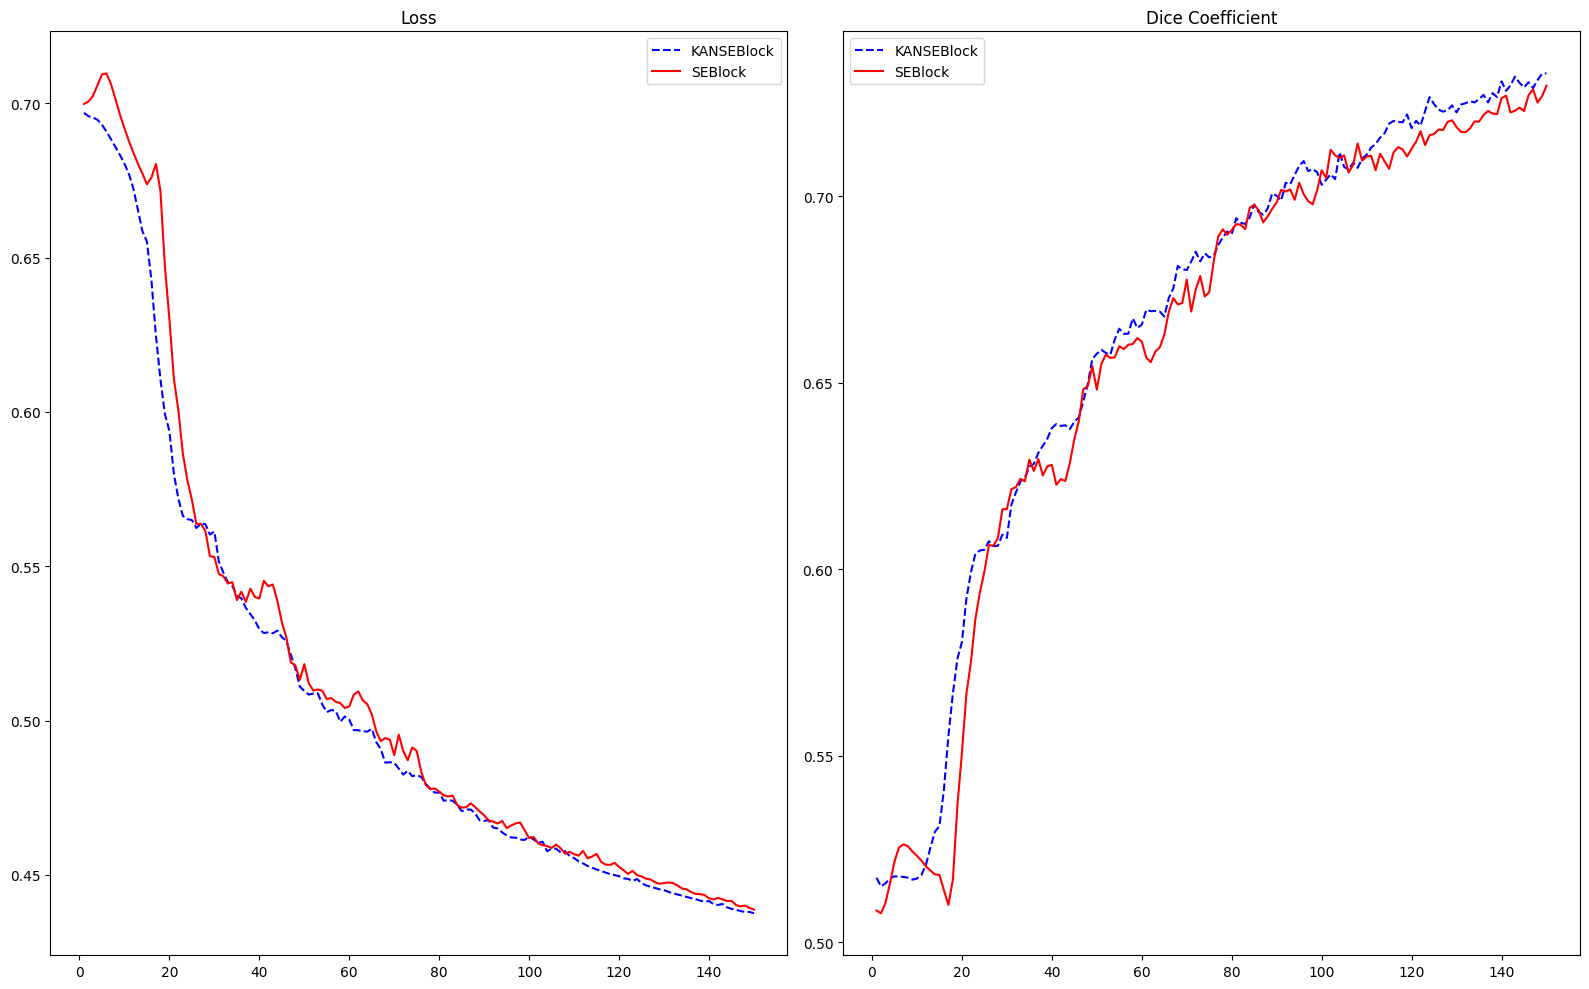

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# ─── Standard SE Block ───────────────────────────────────────
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        mid_channels = max(1, in_channels // reduction)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, mid_channels)
        self.fc2 = nn.Linear(mid_channels, in_channels)
        self.activation = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        B, C, H, W = x.shape
        z = self.global_pool(x).view(B, C)
        h = self.activation(self.fc1(z))
        s = self.sigmoid(self.fc2(h)).view(B, C, 1, 1)
        return x * s

# ─── KANSEBlock ──────────────────────────────────────────────
class KANSEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        mid_channels = max(1, in_channels // reduction)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, mid_channels)
        self.fc2 = nn.Linear(mid_channels, in_channels)
        self.activation = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        B, C, H, W = x.shape
        z = self.global_pool(x).view(B, C)
        h = self.activation(self.fc1(z))
        s = self.sigmoid(self.fc2(h)).view(B, C, 1, 1)
        return x * s

# ─── UNet Block with Option for KAN or SE ────────────────────
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_kan=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            KANSEBlock(out_channels) if use_kan else SEBlock(out_channels)
        )

    def forward(self, x):
        return self.conv(x)

# ─── Training and Validation Function ─────────────────────────
def train_validate_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=150, device='cpu'):
    history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_losses, train_dices = [], []

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            probs = torch.sigmoid(outputs)
            train_losses.append(loss.item())
            train_dices.append((2. * (probs * masks).sum() / (probs + masks).sum()).item())

        model.eval()
        val_losses, val_dices = [], []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                probs = torch.sigmoid(outputs)
                val_losses.append(loss.item())
                val_dices.append((2. * (probs * masks).sum() / (probs + masks).sum()).item())

        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))
        history['train_dice'].append(np.mean(train_dices))
        history['val_dice'].append(np.mean(val_dices))

    return model, history

# ─── Compare KANSEBlock vs SEBlock ───────────────────────────
def compare_models():
    images = torch.rand(100,1,64,64)
    masks = (images > 0.5).float()

    dataset = TensorDataset(images, masks)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=8)

    criterion = nn.BCEWithLogitsLoss()

    # Train with KANSEBlock
    model_kan = UNetBlock(1, 1, use_kan=True)
    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=1e-3)
    model_kan, history_kan = train_validate_model(model_kan, train_loader, val_loader, optimizer_kan, criterion)

    # Train with SEBlock
    model_se = UNetBlock(1, 1, use_kan=False)
    optimizer_se = torch.optim.Adam(model_se.parameters(), lr=1e-3)
    model_se, history_se = train_validate_model(model_se, train_loader, val_loader, optimizer_se, criterion)

    # Visualization Function for Comparison
    def plot_comparison(history_kan, history_se):
        epochs = range(1, len(history_kan['train_loss'])+1)

        plt.figure(figsize=(16, 10))
        metrics = ['Loss', 'Dice Coefficient']
        keys = ['val_loss', 'val_dice']

        for i, key in enumerate(keys):
            plt.subplot(1, 2, i+1)
            plt.plot(epochs, history_kan[key], label='KANSEBlock', linestyle='dashed', color='blue')
            plt.plot(epochs, history_se[key], label='SEBlock', linestyle='solid', color='red')
            plt.title(metrics[i])
            plt.legend()

        plt.tight_layout()
        plt.show()

    plot_comparison(history_kan, history_se)

# Run the comparison
compare_models()
